In [3]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm, trange
import torch
import torch.nn.functional as F
tqdm.pandas()

### Create data splits

In [4]:
root = "/data/nicola/WSH/"

In [5]:
## Load occurences
species_habitats_records = pd.read_json("./processed_data/species_habitats_records.json", orient="records")
species_habitats_records.head(10)

,zone_id,grid_id,TypoCH_NUM,species_key,shape_area,canton,split
0,96603,1537,454,2891147,102800.130038,VD,test
1,95033,1625,625,3170040,57464.263336,VD,train
2,94466,1713,452,2891147,69785.151723,VD,train
3,94462,1713,453,5371685,104539.091134,VD,train
4,94901,1804,625,1703827,36810.089390,VD,train
5,94371,1892,454,5405976,145896.189994,VD,train
6,94371,1892,454,3033289,145896.189994,VD,train
7,94862,2070,452,3170040,80215.598566,VD,train
8,94862,2070,452,5386897,80215.598566,VD,train
9,94862,2070,452,3170040,80215.598566,VD,train


In [6]:
species_habitats_records.split.value_counts()

train    734497
test     316774
val       47312
Name: split, dtype: int64

In [7]:
## Load habitat types
habitatsData = pd.read_json("./WikiSpeciesHabitats/habitatsData.json", orient="records").set_index("TypoCH_NUM")
habitatsData.head(10)

,TypoCH_DE,TypoCH_FR,TypoCH_IT,TypoCH_Sci,Class,Group_,Type,Source
TypoCH_NUM,,,,,,,,
1,1 Gewässer,1 Eaux libres,1 Ambienti acquatici,None,1,1,1,1
11,1.1 Stehende Gewässer,1.1 Eaux calmes,1.1 Acque ferme,None,1,11,11,1
12,1.2 Fliessgewässer,1.2 Eaux courantes,1.2 Acque correnti,None,1,12,12,1
2,2 Ufer und der Feuchtgebiete,2 Rivages et lieux humides,2 Rive e luoghi umidi,None,2,2,2,1
21,2.1 Ufer mit Vegetation,2.1 Rivages avec végétation,2.1 Rive con copertura vegetale,None,2,21,21,1
211,2.1.1 Moortümpelgesellschaft,2.1.1 Dépression inondée à utriculaires,2.1.1 Depressioni allagate con Erba-vescica,Sphagno-Utricularion,2,21,211,1
212,2.1.2 Röhricht,2.1.2 Roselière,2.1.2 Canneti,None,2,21,212,2
2121,2.1.2.1 Stillwasser-Röhricht,2.1.2.1 Roselière lacustre,2.1.2.1 Canneti lacustri,Phragmition,2,21,212,2
2122,2.1.2.2 Flussufer- und Landröhricht,2.1.2.2 Roselière terrestre,"2.1.2.2 Canneti terrestri, ripariali",Phalaridion,2,21,212,2


In [8]:
## Merge both sources
species_habitats_records = species_habitats_records.join(habitatsData[["Class","Group_","Type"]], on="TypoCH_NUM", how="left")
species_habitats_records = species_habitats_records.rename(columns={"Class": "class", "Group_":"group", "Type": "type"})
species_habitats_records.head(10)

,zone_id,grid_id,TypoCH_NUM,species_key,shape_area,canton,split,class,group,type
0,96603,1537,454,2891147,102800.130038,VD,test,4,45,454
1,95033,1625,625,3170040,57464.263336,VD,train,6,62,625
2,94466,1713,452,2891147,69785.151723,VD,train,4,45,452
3,94462,1713,453,5371685,104539.091134,VD,train,4,45,453
4,94901,1804,625,1703827,36810.089390,VD,train,6,62,625
5,94371,1892,454,5405976,145896.189994,VD,train,4,45,454
6,94371,1892,454,3033289,145896.189994,VD,train,4,45,454
7,94862,2070,452,3170040,80215.598566,VD,train,4,45,452
8,94862,2070,452,5386897,80215.598566,VD,train,4,45,452
9,94862,2070,452,3170040,80215.598566,VD,train,4,45,452


In [11]:
species = species_habitats_records.groupby("species_key")["class"].unique().reset_index().rename(columns={"class":"classes"})
species.head()

,species_key,classes
0,1013335,"[4, 3, 6]"
1,1013651,[4]
2,1035167,"[4, 7, 6, 3, 9, 8]"
3,1035185,"[4, 6, 8, 3, 9]"
4,1035194,"[5, 7, 3, 4, 6, 9]"


<Axes: >

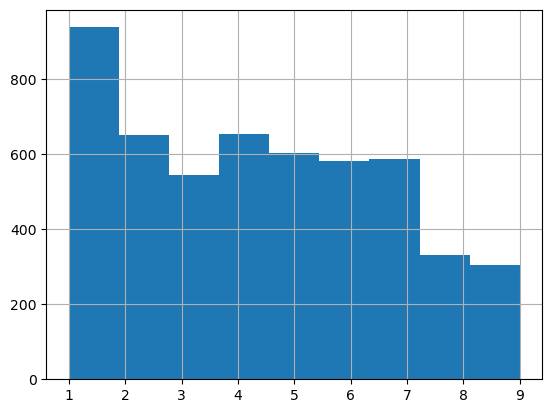

In [12]:
species["classes_count"] = species["classes"].apply(lambda x : len(x))
species["classes_count"].hist(bins=9)

In [13]:
species["classes_onehot"] = species["classes"].apply(lambda x : F.one_hot(torch.tensor(x)-1, num_classes=9).sum(dim=0).tolist())
species.head()

,species_key,classes,classes_count,classes_onehot
0,1013335,"[4, 3, 6]",3,"[0, 0, 1, 1, 0, 1, 0, 0, 0]"
1,1013651,[4],1,"[0, 0, 0, 1, 0, 0, 0, 0, 0]"
2,1035167,"[4, 7, 6, 3, 9, 8]",6,"[0, 0, 1, 1, 0, 1, 1, 1, 1]"
3,1035185,"[4, 6, 8, 3, 9]",5,"[0, 0, 1, 1, 0, 1, 0, 1, 1]"
4,1035194,"[5, 7, 3, 4, 6, 9]",6,"[0, 0, 1, 1, 1, 1, 1, 0, 1]"


In [15]:
len(species_habitats_records.zone_id.unique())

22528

In [16]:
len(species_habitats_records[["zone_id","grid_id"]].drop_duplicates())

22528

### Aggregate data using Class as labels

In [46]:
## Grouping among grid cells and class
dataset_unbalanced = species_habitats_records.groupby(by=["zoneID"])["speciesKey"].agg("unique").reset_index()
dataset_unbalanced["speciesCount"] = dataset_unbalanced["speciesKey"].apply(lambda x : len(x))
dataset_unbalanced.head()

,zoneID,speciesKey,speciesCount
0,9,"[3032837, 3170807, 3105433, 2883073]",4
1,10,[4299368],1
2,13,[2891147],1
3,26,"[5137582, 7799370]",2
4,29,"[5352367, 3170807, 8207244]",3


In [ ]:
def get_labels(keys):
    for key in keys:
        pass

In [ ]:
dataset_unbalanced.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.98])

,gridID,class,speciesCount
count,11634.000000,11634.000000,11634.000000
mean,4520.656696,5.126440,16.128503
std,2703.833576,2.139689,93.350168
min,33.000000,1.000000,1.000000
10%,1288.000000,3.000000,1.000000
20%,1979.000000,3.000000,1.000000
30%,2527.900000,4.000000,2.000000
40%,3171.000000,4.000000,2.000000
50%,4140.000000,5.000000,3.000000
60%,5023.800000,6.000000,5.000000


In [ ]:
dataset_unbalanced["class"].value_counts()

4    3197
6    2259
3    1484
9    1389
5    1086
7     832
1     574
8     482
2     331
Name: class, dtype: int64

In [ ]:
## Remove zones with too much observed species
dataset_unbalanced = dataset_unbalanced[dataset_unbalanced["speciesCount"]<=100].reset_index().drop("index", axis=1)
dataset_unbalanced.describe()

,gridID,class,speciesCount
count,11475.000000,11475.000000,11475.000000
mean,4518.147887,5.129673,7.532723
std,2703.830388,2.145099,11.339111
min,33.000000,1.000000,1.000000
25%,2262.000000,4.000000,1.000000
50%,4138.000000,5.000000,3.000000
75%,6657.000000,6.000000,9.000000
max,11229.000000,9.000000,100.000000


In [ ]:
def split(list_a, chunk_size):
    """From https://www.programiz.com/python-programming/examples/list-chunks"""
    for i in range(0, len(list_a), chunk_size):
        yield list_a[i:i + chunk_size]

In [ ]:
## Divide large samples into smaller ones
allowedSize = 10
dataset = pd.DataFrame()
for i in trange(len(dataset_unbalanced)):
    entry = dataset_unbalanced.loc[i]
    ## If lenght is ok, then just keep the sample
    if len(entry["speciesKey"])<=allowedSize:
        dataset = pd.concat([dataset, pd.DataFrame(entry).T])
    ## Otherwise, shuffle species keys and make chunks of wanted size
    else:
        newline = entry.copy()
        keys = list(entry["speciesKey"])
        random.shuffle(keys)
        for chunk in list(split(keys,chunk_size=allowedSize)):
            newline["speciesKey"] = chunk
            dataset = pd.concat([dataset, pd.DataFrame(newline).T])

dataset["speciesCount"] = dataset["speciesKey"].apply(lambda x : len(x))
dataset = dataset.reset_index().drop("index", axis=1)

  0%|          | 0/11475 [00:00<?, ?it/s]

In [ ]:
dataset.dtypes

gridID          object
class           object
speciesKey      object
speciesCount     int64
dtype: object

In [ ]:
dataset.head()

,gridID,class,speciesKey,speciesCount
0,33,4,"[2441055, 2753146, 3114727, 2159474]",4
1,34,1,[5409958],1
2,34,3,"[8207244, 3170040, 3928139]",3
3,120,4,"[4458814, 1096909, 2926945]",3
4,121,6,"[5389017, 3173338]",2


In [ ]:
dataset.dtypes

gridID          object
class           object
speciesKey      object
speciesCount     int64
dtype: object

In [ ]:
dataset.drop("speciesKey", axis=1).astype(int).describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

,gridID,class,speciesCount
count,16074.000000,16074.000000,16074.000000
mean,4609.592758,5.129215,5.377504
std,2682.832299,2.031002,3.692829
min,33.000000,1.000000,1.000000
10%,1375.000000,3.000000,1.000000
20%,2017.000000,4.000000,1.000000
30%,2559.000000,4.000000,2.000000
40%,3356.000000,4.000000,3.000000
50%,4324.000000,5.000000,5.000000
60%,5195.000000,6.000000,7.000000


In [ ]:
## Mean number of articles per class
meanCounts = pd.DataFrame(dataset.groupby("class")["speciesCount"].mean()).rename(columns={"speciesCount":"avgSpeciesCount"})

In [ ]:
## Checking classes balance
classesRepresentation = pd.DataFrame(dataset["class"].value_counts()).reset_index().rename(columns={"index":"class","class":"occurenceCount"})
classesRepresentation = classesRepresentation.join(meanCounts, on="class", how="inner")
classesRepresentation

,class,occurenceCount,avgSpeciesCount
0,4,5281,6.551032
1,6,3464,6.331986
2,3,1688,3.610782
3,9,1679,4.451459
4,7,1136,5.402289
5,5,1135,2.588546
6,8,665,6.051128
7,1,635,2.911811
8,2,391,3.557545


In [ ]:
## All present species
all_species = []
for i in trange(len(dataset)):
    all_species = all_species+ list(dataset["speciesKey"].loc[i])

all_species = pd.DataFrame(all_species)

  0%|          | 0/16074 [00:00<?, ?it/s]

In [ ]:
all_species = all_species.drop_duplicates().reset_index(drop=True).reset_index().rename(columns={"index":"ID", 0:"speciesKey"})
all_species.to_json("./WikiSpeciesHabitats/speciesKeys.json", orient="records")

In [ ]:
all_species.head()

,ID,speciesKey
0,0,2441055
1,1,2753146
2,2,3114727
3,3,2159474
4,4,5409958


In [ ]:
## Get classes keys and names
classesdf = pd.DataFrame(dataset["class"].unique()).rename(columns={0:"class"})
classesdf = classesdf.join(habitatsData[["TypoCH_DE","TypoCH_FR","TypoCH_IT"]], on="class", how="left")
classesdf.sort_values(by="class").reset_index().drop("index", axis=1).to_json("./WikiSpeciesHabitats/habitatsKeys.json", orient="records")
classesdf

,class,TypoCH_DE,TypoCH_FR,TypoCH_IT
0,4,"4 Grünland (Naturrasen, Wiesen und Weiden)",4 Pelouses et prairies,4 Praterie
1,1,1 Gewässer,1 Eaux libres,1 Ambienti acquatici
2,3,"3 Sand, Kies, Stein, Schotter usw","3 Sable, gravier, pierre, pierre concassée, etc.","3 Sabbia, ghiaia, pietra, pietrisco, ecc"
3,6,6 Wälder,6 Forêts,6 Ambienti boscati
4,9,"9 Bauten, Anlagen",9 Milieux construits,9 Ambienti edificati e infrastrutture
5,5,"5 Krautsäume, Hochstaudenfluren und Gebüsche","5 Landes, lisières et mégaphorbiaies","5 Margini di bosco, radure, aggregati di alte ..."
6,7,7 Pioniervegetation gestörter Plätze (Ruderals...,7 Végétation pionnière des endroits perturbés ...,7 Ambienti ruderali e perturbati dall'uomo
7,8,"8 Pflanzungen, Äcker und Kulturen","8 Plantations, champs et cultures",8 Ambienti coltivati
8,2,2 Ufer und der Feuchtgebiete,2 Rivages et lieux humides,2 Rive e luoghi umidi


In [ ]:
## Training data (70% train, 15% val, 15% test)
trainData = dataset.sample(frac=0.7)
remaining = dataset.drop(trainData.index)
valData = remaining.sample(frac=0.5)
testData = remaining.drop(valData.index)


In [ ]:
trainData.drop("speciesKey", axis=1).astype(int).describe()

,gridID,class,speciesCount
count,11252.000000,11252.000000,11252.000000
mean,4609.524173,5.127888,5.379666
std,2683.177297,2.029972,3.695624
min,34.000000,1.000000,1.000000
25%,2302.750000,4.000000,2.000000
50%,4321.000000,5.000000,5.000000
75%,6716.250000,6.000000,10.000000
max,11229.000000,9.000000,10.000000


In [ ]:
trainData.head()

,gridID,class,speciesKey,speciesCount
7143,3794,4,"[9063248, 3085438, 3117449, 3003979, 2739836, ...",10
14474,8493,4,"[2482613, 2480506, 7745240, 5229167, 5229490, ...",10
12373,6918,6,"[3105433, 7331633, 3033894, 5334220, 2889173]",5
10259,5545,3,[5384754],1
13151,7429,5,[2770228],1


In [ ]:
valData.drop("speciesKey", axis=1).astype(int).describe()

,gridID,class,speciesCount
count,2411.000000,2411.000000,2411.000000
mean,4585.633347,5.126504,5.383243
std,2662.224986,2.028471,3.695567
min,120.000000,1.000000,1.000000
25%,2290.500000,4.000000,2.000000
50%,4314.000000,4.000000,5.000000
75%,6658.500000,6.000000,10.000000
max,11224.000000,9.000000,10.000000


In [ ]:
testData.drop("speciesKey", axis=1).astype(int).describe()

,gridID,class,speciesCount
count,2411.000000,2411.000000,2411.000000
mean,4633.872252,5.138117,5.361676
std,2702.573389,2.039141,3.678502
min,33.000000,1.000000,1.000000
25%,2285.500000,4.000000,2.000000
50%,4400.000000,5.000000,5.000000
75%,6747.500000,6.000000,10.000000
max,11224.000000,9.000000,10.000000


In [ ]:
## Save splits
trainData.reset_index().drop("index", axis=1).to_json("./WikiSpeciesHabitats/trainData.json", orient="records")
valData.reset_index().drop("index", axis=1).to_json("./WikiSpeciesHabitats/valData.json", orient="records")
testData.reset_index().drop("index", axis=1).to_json("./WikiSpeciesHabitats/testData.json", orient="records")

In [ ]:
## Divide large samples into smaller ones
allowedSize = 1
dataset2 = pd.DataFrame()
for i in trange(len(dataset)):
    entry = dataset.loc[i]
    ## If lenght is ok, then just keep the sample
    if len(entry["speciesKey"])<=allowedSize:
        dataset2 = pd.concat([dataset2, pd.DataFrame(entry).T])
    ## Otherwise, shuffle species keys and make chunks of wanted size
    else:
        newline = entry.copy()
        keys = list(entry["speciesKey"])
        random.shuffle(keys)
        for chunk in list(split(keys,chunk_size=allowedSize)):
            newline["speciesKey"] = chunk
            dataset2 = pd.concat([dataset2, pd.DataFrame(newline).T])

dataset2["speciesKey"] = dataset2["speciesKey"].apply(lambda x : x[0])
dataset2 = dataset2.reset_index().drop("index", axis=1)

  0%|          | 0/16074 [00:00<?, ?it/s]

In [ ]:
dataset2 = pd.DataFrame(dataset2.groupby("class")["speciesKey"].unique())
dataset2["numSpecies"] = dataset2["speciesKey"].apply(lambda x : len(x))
dataset2

,speciesKey,numSpecies
class,,
1,"[5409958, 2888948, 2490255, 3033339, 3034714, ...",644
2,"[3033289, 2730127, 2883073, 3032585, 9490132, ...",553
3,"[3170040, 8207244, 3928139, 7270316, 2891147, ...",1238
4,"[2753146, 2159474, 2441055, 3114727, 4458814, ...",2601
5,"[5149438, 5405976, 5357013, 5352367, 7270427, ...",820
6,"[5389017, 3173338, 2650669, 2857601, 3170040, ...",2339
7,"[5231190, 2489214, 2889173, 5228676, 6065824, ...",1499
8,"[3033558, 2773942, 2889173, 2481800, 3021496, ...",1100
9,"[1862719, 3170040, 3173338, 3034681, 5420853, ...",1544
